In [1]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from collections import Counter
import re
import string
import pickle
import json
import numpy as np


2025-05-08 14:34:09.368546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:34:09.369289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:34:09.371530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:34:09.377960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746689649.388328   77963 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746689649.39

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/akeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/akeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/akeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# === LOAD DATA ===
with open("../dataset/dataset_ner_srl.json", "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = [[token.lower() for token in item["tokens"]] for item in data]
ner_labels = [item["labels_ner"] for item in data]
srl_labels = [item["labels_srl"] for item in data]

print(len(sentences), "sentences")

# === COUNTERS ===
ner_counter = Counter()
srl_counter = Counter()

for ner_seq in ner_labels:
    ner_counter.update(ner_seq)

for srl_seq in srl_labels:
    srl_counter.update(srl_seq)

# === PRINT RESULT ===
print("=== NER LABEL COUNTS ===")
for label, count in ner_counter.items():
    print(f"{label} -> {count} labels")

print("\n=== SRL LABEL COUNTS ===")
for label, count in srl_counter.items():
    print(f"{label} -> {count} labels")

158 sentences
=== NER LABEL COUNTS ===
O -> 1495 labels
B-LOC -> 100 labels
B-MISC -> 6 labels
B-TIME -> 46 labels
I-TIME -> 37 labels
I-LOC -> 19 labels
B-QUANT -> 4 labels
I-QUANT -> 5 labels
B-DATE -> 42 labels
B-REL -> 2 labels
B-ETH -> 2 labels
I-ETH -> 2 labels
B-ORG -> 9 labels
I-ORG -> 5 labels
B-MIN -> 6 labels
B-TERM -> 2 labels
I-TERM -> 3 labels
B-RES -> 8 labels
I-RES -> 2 labels
B-PER -> 13 labels
I-PER -> 16 labels
I-DATE -> 34 labels
I-MISC -> 4 labels
B-EVENT -> 4 labels
I-EVENT -> 4 labels

=== SRL LABEL COUNTS ===
ARG1 -> 421 labels
ARGM-LOC -> 65 labels
AM-NEG -> 2 labels
V -> 196 labels
ARGM-SRC -> 13 labels
O -> 320 labels
AM-QUE -> 5 labels
ARGM-BNF -> 6 labels
ARG2 -> 184 labels
ARGM-MNR -> 9 labels
ARG0 -> 129 labels
AM-TMP -> 279 labels
AM-PRP -> 1 labels
AM-MOD -> 5 labels
AM-ADV -> 1 labels
AM-CAU -> 14 labels
AM-EXT -> 6 labels
AM-MNR -> 22 labels
AM-DIS -> 2 labels
AM-FRQ -> 2 labels
ARGM-PNC -> 4 labels
R-ARG1 -> 3 labels
AM-LOC -> 78 labels
AM-DIR -> 4 l

In [4]:
# text preprocessing
stop_words = set(stopwords.words("indonesian"))                                                                                                                                                                                                                                                                             
factory = StemmerFactory()
stemmer = factory.create_stemmer()

with open("../normalize_text/normalize.json", "r", encoding="utf-8") as file:
    normalization_dict = json.load(file)
    
def text_preprocessing(text):
    
    # if(text == "?" or text == "." or text == "!"): return text
    # lowercase
    text = text.lower()
    
    # remove punctuation
    # text = text.translate(str.maketrans("", "", string.punctuation))
    
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # tokenize
    # tokens = word_tokenize(text)
    
    # normalization
    # tokens = normalization_dict.get(text, text)  
  
    
    # stemming
    # tokens = stemmer.stem(tokens)
    
    
    # remove stopwords
    # tokens = [word for word in tokens if word not in stop_words]
    
    # print(f"Original: {text}")
    # print(f"Normalized: {tokens}")
    
    return text

# sentences = [text_preprocessing(" ".join(sentence)) for sentence in sentences]
print("old", sentences)
preprocessing_sentences = []

for text in sentences:
    result = []
    for i in range(len(text)):
        text[i] = text_preprocessing(text[i])
        result.append(text[i])
    preprocessing_sentences.append(result)

print("new", preprocessing_sentences, "\n", len(preprocessing_sentences))

    

old [['keberagaman', 'potensi', 'sumber', 'daya', 'alam', 'indonesia', 'tidak', 'lepas', 'dari', 'proses', 'geografis', 'yang', 'terjadi', '.'], ['bagaimana', 'proses', 'geografis', 'di', 'indonesia', '?'], ['bagaimana', 'pengaruh', 'proses', 'geografis', 'bagi', 'keragaman', 'alam', 'dan', 'keragaman', 'sosial', 'masyarakat', 'indonesia', '?'], ['bagaimana', 'mengoptimalkan', 'peranan', 'sumber', 'daya', 'manusia', 'dalam', 'mengelola', 'sumber', 'daya', 'alam', 'indonesia', '?'], ['apakah', 'sumber', 'daya', 'manusia', 'di', 'indonesia', 'sudah', 'memenuhi', 'syarat', 'untuk', 'mengolah', 'pariwisata', 'yang', 'dimilikinya', '?'], ['bagaimana', 'lembaga', 'sosial', 'yang', 'akan', 'mewadahi', 'untuk', 'mengolah', 'sumber', 'daya', 'alam', 'dan', 'sumber', 'daya', 'manusianya', '?'], ['kalian', 'juga', 'perlu', 'memahami', ',', 'bahwa', 'keragaman', 'sosial', 'dan', 'budaya', 'telah', 'menarik', 'kedatangan', 'bangsa-bangsa', 'asing', 'sejak', 'ribuan', 'tahun', 'yang', 'lalu', '.'], 

In [5]:
words = list(set(word for sentence in preprocessing_sentences for word in sentence))
word2idx = {word: idx + 2 for idx, word in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

all_ner_tags = sorted(set(tag for seq in ner_labels for tag in seq))
all_srl_tags = sorted(set(tag for seq in srl_labels for tag in seq))
tag2idx_ner = {tag: idx for idx, tag in enumerate(all_ner_tags)}
tag2idx_srl = {tag: idx for idx, tag in enumerate(all_srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

print(words)
print(word2idx)
print(all_ner_tags)
print(all_srl_tags)
print(tag2idx_ner)
print(tag2idx_srl)
print(idx2tag_ner)
print(idx2tag_srl)

['alarm', 'sempit', 'sore', '05.45', 'pecaharian', 'alat', 'langsung', 'pantai', 'kebijakan', 'dipengaruhi', 'hidrat', 'perak', '11', 'membatasi', 'wilayah', 'perairan', 'kedatangan', 'diselenggarakan', 'jauh', 'penyerbukan', 'barang-barang', 'tiba', 'sama', 'diaz', 'ombak', 'terluas', 'negara-negara', 'menarik', 'kering', 'mewadahi', 'semakin', '1998', 'sendiri', 'keturunan', 'simbol', 'diminta', 'sekitarnya', 'kemarau', 'bartholomeus', 'februari', 'keberagaman', '?', 'kanan', 'pertambangan', 'pbb', 'harian', '1949', 'jatuhnya', 'curah', 'faktor', 'sangat', 'sistem', 'tropis', 'terdiri', 'anggota', 'perkembangan', 'ada', 'pengalaman', 'kapal', 'beraneka', 'resources', 'perang', 'penduduk', 'alami', 'geografis', 'disebabkan', 'nelayan', 'manusia', 'mengolah', 'luas', 'toko', 'lembaga', 'menjadi', 'waktu', 'suatu', '2004', 'ini', 'setelah', 'pit', '3', 'buka', 'agama', 'mengoptimalkan', 'rata-rata', 'terjadi', 'tentang', 'pemuda', 'permukaan', 'disegani', 'kelembaban', '1950', 'makanan'

In [6]:

# === ENCODING ===
X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in ts] for ts in ner_labels]
y_srl = [[tag2idx_srl[t] for t in ts] for ts in srl_labels]

maxlen = 50

X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])

y_ner_cat = [to_categorical(seq, num_classes=len(tag2idx_ner)) for seq in y_ner]
y_srl_cat = [to_categorical(seq, num_classes=len(tag2idx_srl)) for seq in y_srl]

print(X)
print("y_ner \n ")
print(y_ner)
print("y_srl \n ")
print(y_srl)
print("y_ner cat \n ")
print(y_ner_cat)
print("y_srl cat \n ")
print(y_srl_cat)


[[ 42 551 425 ...   0   0   0]
 [ 96 433  66 ...   0   0   0]
 [ 96 575 433 ...   0   0   0]
 ...
 [641 496 429 ...   0   0   0]
 [672 486  10 ...   0   0   0]
 [593 151 203 ...   0   0   0]]
y_ner 
 
[[24 24 24 ... 24 24 24]
 [24 24 24 ... 24 24 24]
 [24 24 24 ... 24 24 24]
 ...
 [24  0 24 ... 24 24 24]
 [24 24 24 ... 24 24 24]
 [24 24  0 ... 24 24 24]]
y_srl 
 
[[16 16 16 ... 35 35 35]
 [13 16 16 ... 35 35 35]
 [13 16 16 ... 35 35 35]
 ...
 [14 14 35 ... 35 35 35]
 [15 37 16 ... 35 35 35]
 [16 16 14 ... 35 35 35]]
y_ner cat 
 
[array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., 

In [7]:
# split dataset 
X_temp, X_test, y_ner_temp, y_ner_test, y_srl_temp, y_srl_test = train_test_split(
    X, y_ner_cat, y_srl_cat, test_size=0.1, random_state=42
)
X_train, X_val, y_ner_train, y_ner_val, y_srl_train, y_srl_val = train_test_split(
    X_temp, y_ner_temp, y_srl_temp, test_size=0.1111, random_state=42  # ~10% of total
)

In [8]:
#training model
input_layer = Input(shape=(maxlen,))
embedding = Embedding(input_dim=len(word2idx), output_dim=64)(input_layer)
bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(embedding)
out_ner = TimeDistributed(Dense(len(tag2idx_ner), activation="softmax"), name="ner_output")(bilstm)
out_srl = TimeDistributed(Dense(len(tag2idx_srl), activation="softmax"), name="srl_output")(bilstm)

model = Model(inputs=input_layer, outputs=[out_ner, out_srl])
model.compile(
    optimizer="adam",
    loss={"ner_output": "categorical_crossentropy", "srl_output": "categorical_crossentropy"},
    metrics={"ner_output": "accuracy", "srl_output": "accuracy"}
)

model.summary()

2025-05-08 14:34:12.231050: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │     45,184 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 128)   │     66,048 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 50, 25)    │      3,225 │ bidirectional[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 50, 38)    │      4,902 │ bidirectional[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,359 (466.25 KB)

 Trainable params: 119,359 (466.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.6158 - ner_output_accuracy: 0.9415 - ner_output_loss: 1.4945 - srl_output_accuracy: 0.7447 - srl_output_loss: 2.1213 - val_loss: 0.7665 - val_ner_output_accuracy: 0.9463 - val_ner_output_loss: 0.2785 - val_srl_output_accuracy: 0.8550 - val_srl_output_loss: 0.4881
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8915 - ner_output_accuracy: 0.9478 - ner_output_loss: 0.2724 - srl_output_accuracy: 0.8253 - srl_output_loss: 0.6190 - val_loss: 0.6997 - val_ner_output_accuracy: 0.9463 - val_ner_output_loss: 0.2667 - val_srl_output_accuracy: 0.8538 - val_srl_output_loss: 0.4330
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7365 - ner_output_accuracy: 0.9564 - ner_output_loss: 0.2132 - srl_output_accuracy: 0.8416 - srl_output_loss: 0.5233 - val_loss: 0.6682 - val_ner_output_accuracy: 0.9463 - val_ner_output_loss: 0.2577 - val_srl_output_accuracy: 0.8575 - val_srl_output_loss: 0.4105
Epoch 4/10
63/63 ━━━━━━━━━━

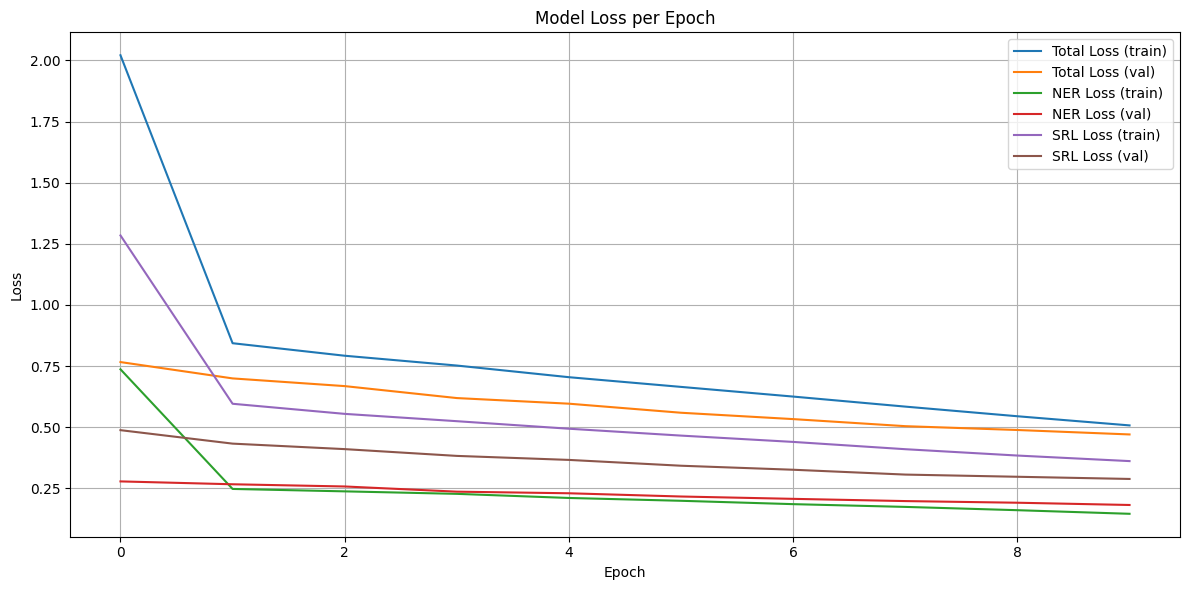

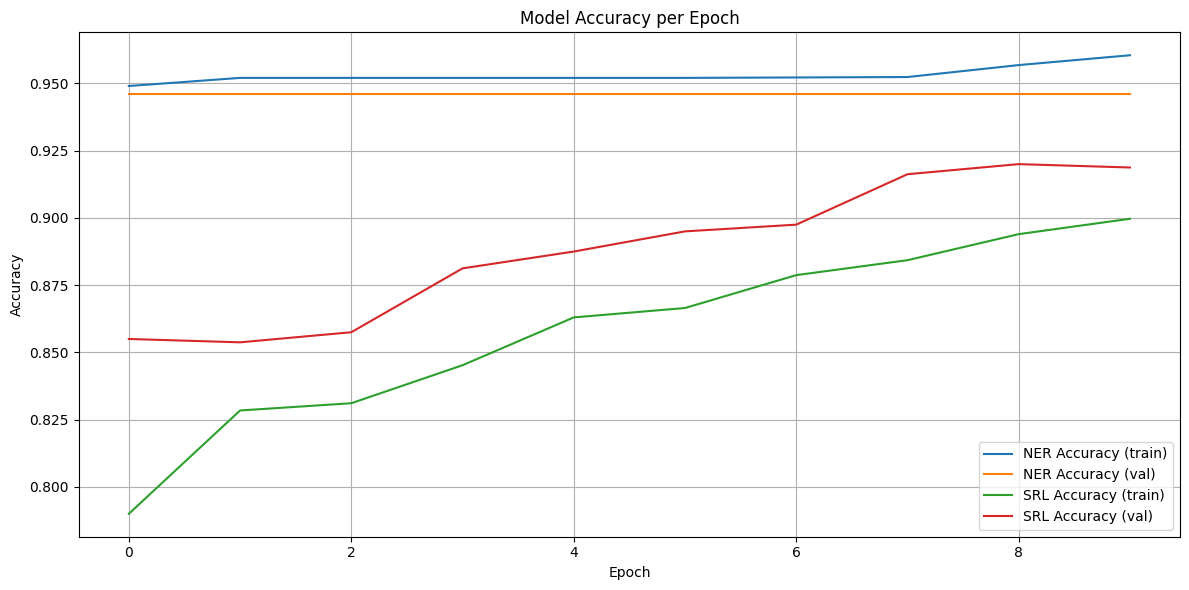

In [9]:

# === TRAINING ===
history = model.fit(
    X_train,
    {"ner_output": np.array(y_ner_train), "srl_output": np.array(y_srl_train)},
    validation_data=(X_val, {"ner_output": np.array(y_ner_val), "srl_output": np.array(y_srl_val)}),
    batch_size=2,
    epochs=10
)

# === SAVE ===
model.save("multi_task_bilstm_model.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)
    
    
history_dict = history.history

# === LOSS ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["loss"], label="Total Loss (train)")
plt.plot(history_dict["val_loss"], label="Total Loss (val)")
plt.plot(history_dict["ner_output_loss"], label="NER Loss (train)")
plt.plot(history_dict["val_ner_output_loss"], label="NER Loss (val)")
plt.plot(history_dict["srl_output_loss"], label="SRL Loss (train)")
plt.plot(history_dict["val_srl_output_loss"], label="SRL Loss (val)")

plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === ACCURACY ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["ner_output_accuracy"], label="NER Accuracy (train)")
plt.plot(history_dict["val_ner_output_accuracy"], label="NER Accuracy (val)")
plt.plot(history_dict["srl_output_accuracy"], label="SRL Accuracy (train)")
plt.plot(history_dict["val_srl_output_accuracy"], label="SRL Accuracy (val)")

plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# evaluation
y_pred_ner, y_pred_srl = model.predict(X_test)

y_true_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_ner_test]
y_pred_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_pred_ner]

y_true_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_srl_test]
y_pred_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_pred_srl]

print("\n📊 [NER] Test Set Classification Report:")
print(classification_report(y_true_ner, y_pred_ner))

print("\n📊 [SRL] Test Set Classification Report:")
print(classification_report(y_true_srl, y_pred_srl))


# import numpy as np

# # Prediksi model (output = probabilitas)
# y_pred_ner = model.predict(X_test)[0]
# y_pred_ner_idx = np.argmax(y_pred_ner, axis=-1)
# y_true_ner_idx = np.argmax(y_ner_test, axis=-1)

# # Mapping ke string
# y_pred_ner_str = []
# y_true_ner_str = []

# for y_true_seq, y_pred_seq in zip(y_true_ner_idx, y_pred_ner_idx):
#     true_seq = []
#     pred_seq = []
#     for t, p in zip(y_true_seq, y_pred_seq):
#         if idx2tag_ner[t] != "PAD":
#             true_seq.append(idx2tag_ner[t])
#             pred_seq.append(idx2tag_ner[p])
#     y_true_ner_str.append(true_seq)
#     y_pred_ner_str.append(pred_seq)

# from seqeval.metrics import classification_report
# print("\n📊 [NER] Test Set Classification Report:")
# print(classification_report(y_true_ner_str, y_pred_ner_str))


# from collections import Counter

# flat_preds = [tag for seq in y_pred_ner_str for tag in seq]
# print(Counter(flat_preds))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step

📊 [NER] Test Set Classification Report:
              precision    recall  f1-score   support

        DATE       0.00      0.00      0.00         5
       EVENT       0.00      0.00      0.00         1
         LOC       1.00      0.43      0.60         7
         ORG       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         1
        TIME       0.00      0.00      0.00         4

   micro avg       0.60      0.15      0.24        20
   macro avg       0.17      0.07      0.10        20
weighted avg       0.35      0.15      0.21        20


📊 [SRL] Test Set Classification Report:
              precision    recall  f1-score   support

         CAU       0.00      0.00      0.00         1
         COM       0.00      0.00      0.00         2
         LOC       0.00      0.00      0.00         8
         MNR       0.00      0.00      0.00         2
         MOD       0.00      0.00      0.00         3
         PR

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AM-TMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE t

In [11]:

def plot_confusion_matrix(y_true_flat, y_pred_flat, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

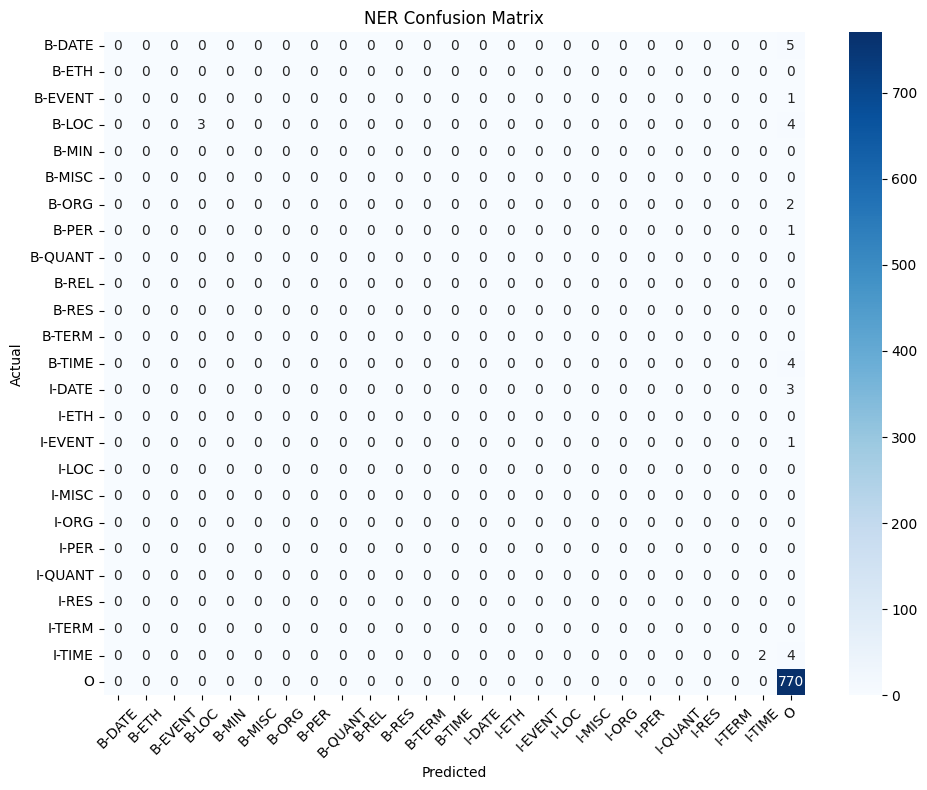

In [12]:

# Flatten label
y_true_flat_ner = [tag for seq in y_true_ner for tag in seq]
y_pred_flat_ner = [tag for seq in y_pred_ner for tag in seq]

# Buat plot
plot_confusion_matrix(
    y_true_flat_ner, 
    y_pred_flat_ner, 
    labels=list(tag2idx_ner.keys()), 
    title="NER Confusion Matrix"
)


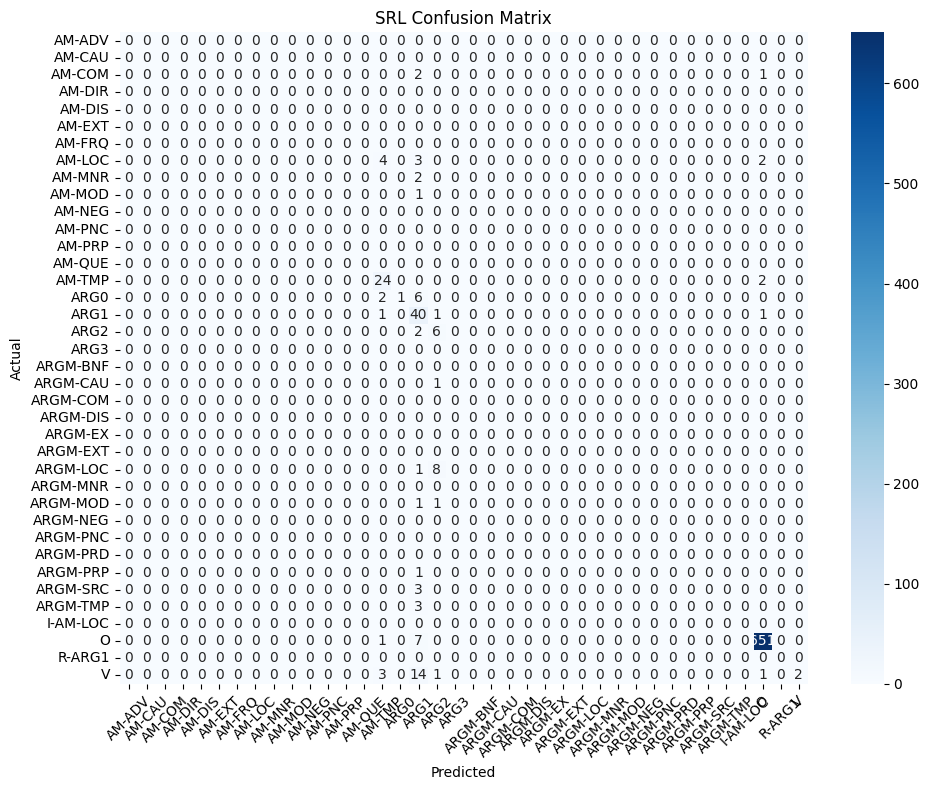

In [13]:
y_true_flat_srl = [tag for seq in y_true_srl for tag in seq]
y_pred_flat_srl = [tag for seq in y_pred_srl for tag in seq]

plot_confusion_matrix(
    y_true_flat_srl, 
    y_pred_flat_srl, 
    labels=list(tag2idx_srl.keys()), 
    title="SRL Confusion Matrix"
)
